In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from gensim.models import Word2Vec, KeyedVectors
from tqdm.auto import tqdm
import random
import diptest



/home/rafa/.pyenv/versions/3.10.12/envs/recsys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load wv vectors and dataset

In [3]:
wv = KeyedVectors.load("word2vec128.wordvectors", mmap='r')
df_playlists = pd.read_csv('data/filtered_playlists.csv', sep='\t')
df_playlists['track_uris'] = df_playlists['track_uris'].apply(lambda x: x.strip('[]').replace("'", "").split(', '))
df_features = pd.read_csv('data/audio_features.csv', sep=',').dropna().drop('Unnamed: 0', axis=1)

/tmp/ipykernel_287042/3430310678.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_features = pd.read_csv('data/audio_features.csv', sep=',').dropna().drop('Unnamed: 0', axis=1)


Create validation set

In [ ]:
val_tracks = set()
for playlist in validation_playlists['track_uris']:
    val_tracks.update(playlist)

# Convert the set to a list if needed
val_tracks = list(val_tracks)

print("Validation Tracks:\n", val_tracks[:5])

validation_playlists.to_csv('data/validation_playlists.csv', sep='\t', index=False, header=True)
train_playlists.to_csv('data/train_playlists.csv', sep='\t', index=False)
val_tracks = pd.DataFrame(val_tracks, columns=['id'])
val_tracks.to_csv('data/validation_features.csv', sep=',', index=False)

In [3]:
validation_playlists = pd.read_csv('data/validation_playlists.csv', sep='\t')
validation_playlists['track_uris'] = validation_playlists['track_uris'].apply(lambda x: x.strip('[]').replace("'", "").split(', '))
train_playlists = df_playlists.drop(validation_playlists.index)
val_tracks = pd.read_csv('data/validation_features.csv', sep=',')

Convert feature columns to numeric

In [18]:
columns = [col for col in df_features.columns if col != 'id']
df_features[columns] = df_features[columns].apply(pd.to_numeric, errors='coerce')
df_features.dropna(inplace=True)
# Find multimodal data:
for column in columns:
    data = np.msort(df_features[column].values)
    print(f"{column}: {diptest.diptest(data)[0]}")
    

/tmp/ipykernel_287042/1609254606.py:6: DeprecationWarning: msort is deprecated, use np.sort(a, axis=0) instead
  data = np.msort(df_features[column].values)
/home/rafa/.pyenv/versions/3.10.12/envs/recsys/lib/python3.10/site-packages/diptest/consts.py:702: UserWarning: Sample size exceeds the maximum limit of 72000. Results may not be accurate with precomputed statistical values.
  warnings.warn(


danceability: 0.0011165492841272429
energy: 0.0019103365869917997
key: 0.06661603040890973
loudness: 0.00014661682741640806
mode: 0.1726152289343883
speechiness: 0.0017657446969164235
acousticness: 0.033530418821923716
instrumentalness: 0.04928398053769129
liveness: 0.00540241548527046
valence: 0.008251829278585216
tempo: 0.010149323709230596
duration_ms: 0.0005002118070904808
time_signature: 0.05072036865431949


In [4]:
df_features["acoustic_bin"] = df_features["acousticness"] > df_features["acousticness"].mean()
df_features["valence_bin"] = df_features["valence"] > df_features["valence"].mean()
df_features["instrumental_bin"] = df_features["instrumentalness"] > df_features["instrumentalness"].mean()

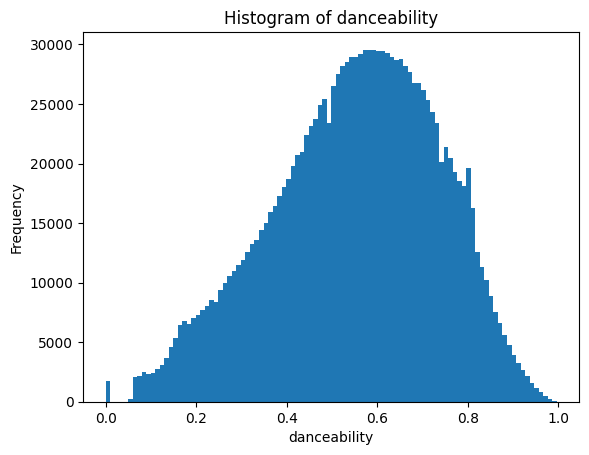

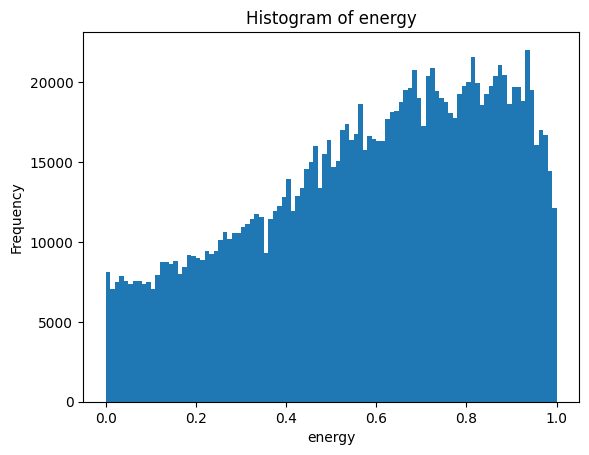

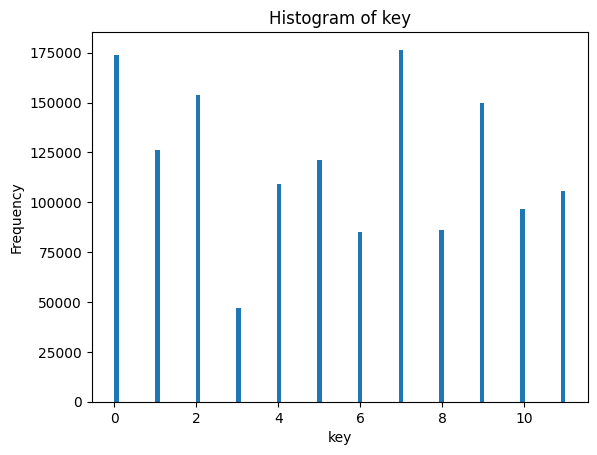

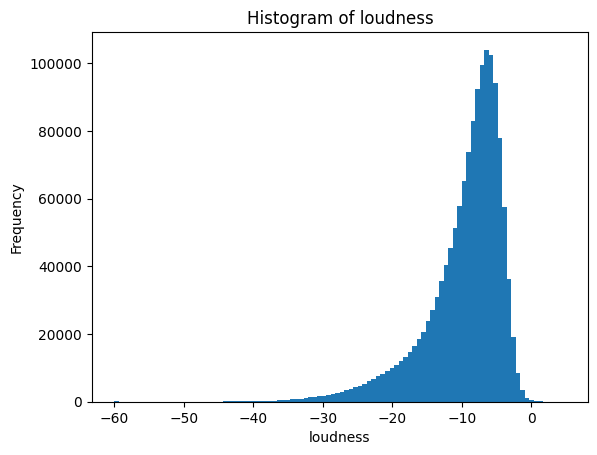

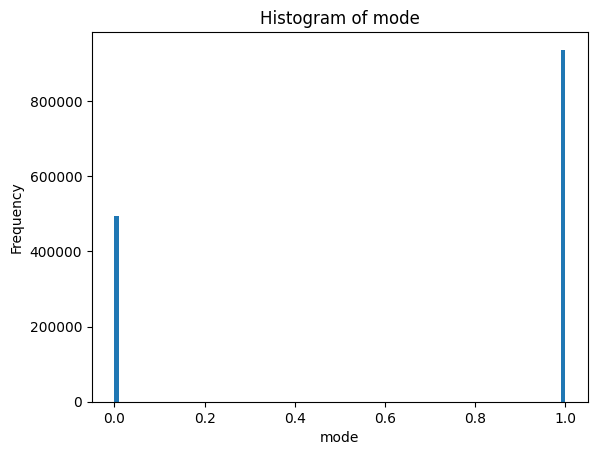

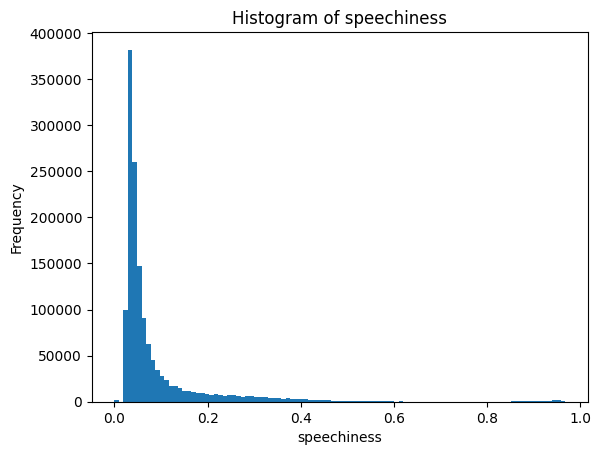

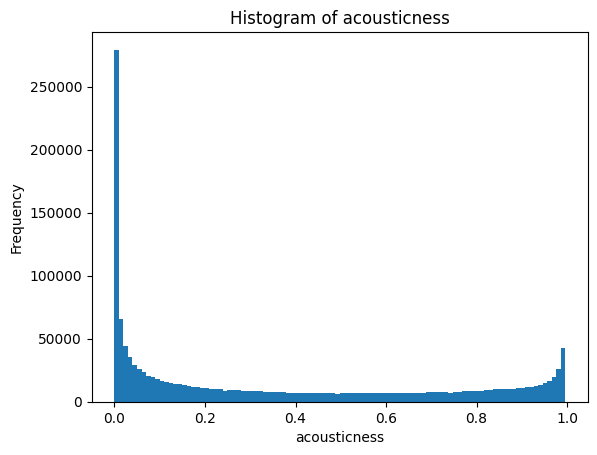

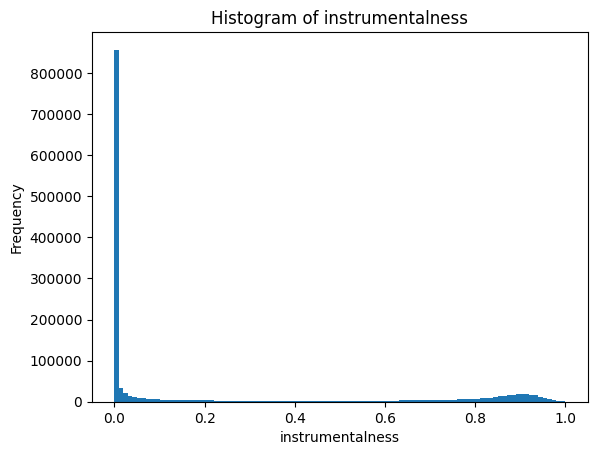

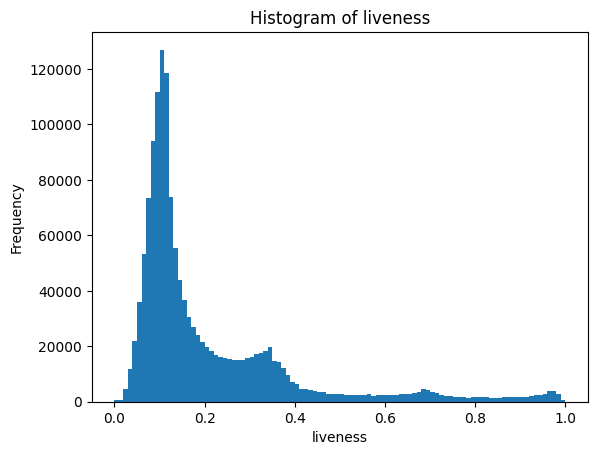

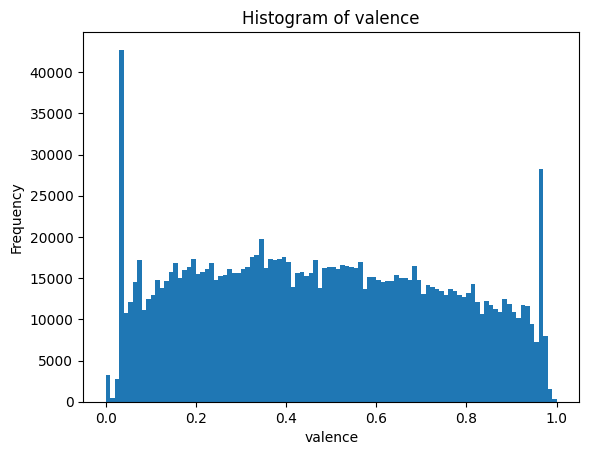

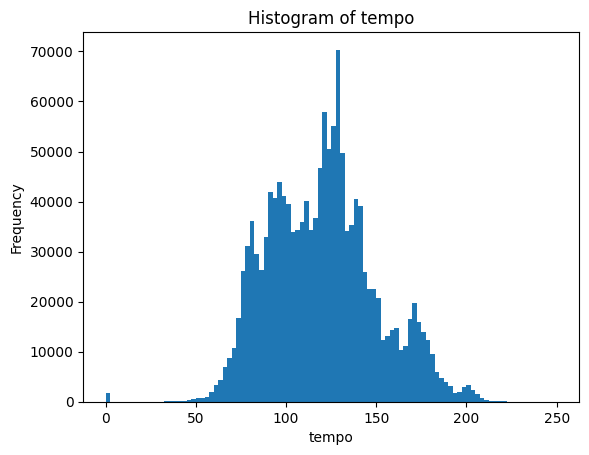

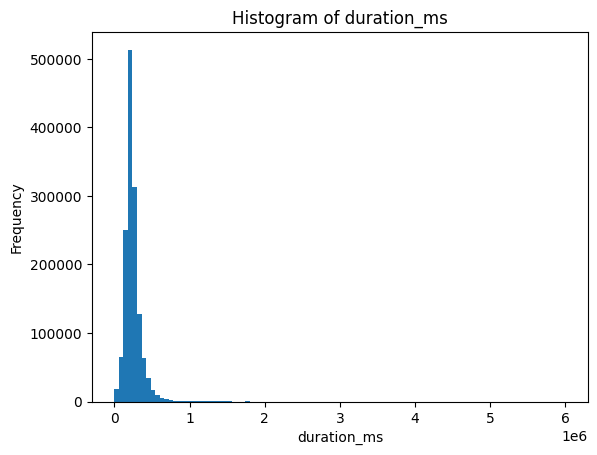

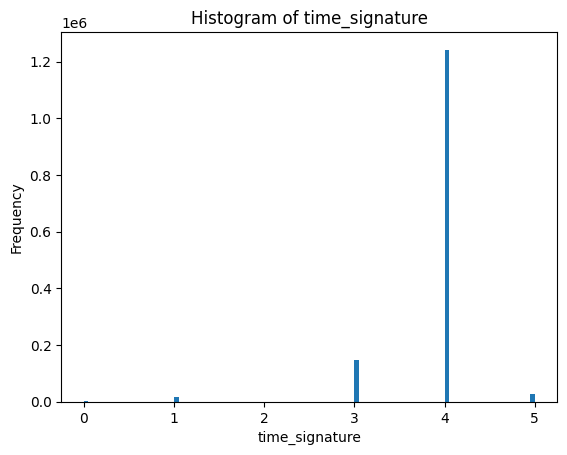

In [16]:

import matplotlib.pyplot as plt

# Plot histograms for each column
for col in columns:
    plt.hist(df_features[col], bins=100)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [5]:
# Dataset class for contrastive learning
class ContrastiveSongDataset(Dataset):
    def __init__(self, songs_df, playlists_df, wv, features = ['acoustic_bin', 'valence_bin', 'instrumental_bin', 'mode', 'key']):
        self.features = features
        self.songs_df = songs_df
        self.playlists_df = playlists_df
        self.wv = wv
        
        # Create a dictionary mapping each song to its playlists
        self.song_to_playlists = {}
        print('Creating song to playlist mapping')
        for idx, row in tqdm(playlists_df.iterrows(), total=len(playlists_df)):
            playlist = row['track_uris']
            for song in playlist:
                if song not in self.song_to_playlists:
                    self.song_to_playlists[song] = []
                self.song_to_playlists[song].append(idx)
        
        # Create a dictionary mapping each audio feature class to its songs
        self.feature_to_songs = {}
        print('Creating feature to song mapping')
        for idx, row in tqdm(songs_df.iterrows(), total=len(songs_df)):
            song_id = row['id']
            for feature in self.features:
                feature_class = row[feature]
                if feature not in self.feature_to_songs.keys():
                    self.feature_to_songs[feature] = {}
                if feature_class not in self.feature_to_songs[feature]:
                    self.feature_to_songs[feature][feature_class] = []
                self.feature_to_songs[feature][feature_class].append(song_id)

    def __len__(self):
        return len(self.songs_df)
    
    def __getitem__(self, idx):
        anchor = self.songs_df.iloc[idx]
        anchor_id = anchor['id']
        positive_feature_ids = []
        negative_feature_ids = []
        for feature in self.features:
            feature_class = anchor[feature]
            # Find a positive pair with the same audio feature class
            positive_id = random.choice(self.feature_to_songs[feature][feature_class])
            while positive_id == anchor_id:
                positive_id = random.choice(self.feature_to_songs[feature][feature_class])
            positive_feature_ids.append(positive_id)

            negative_feature_class = random.choice(list(set(self.feature_to_songs[feature].keys()) - {feature_class}))
            negative_id = random.choice(self.feature_to_songs[feature][negative_feature_class])
            negative_feature_ids.append(negative_id)
        
        # Find a song in the same playlist
        same_playlist_id = anchor_id
        if anchor_id in self.song_to_playlists:
            same_playlist_id = random.choice(self.song_to_playlists[anchor_id])
            while same_playlist_id == anchor_id:
                same_playlist_id = random.choice(self.song_to_playlists[anchor_id])
        
        # Find a song not in the same playlist
        not_same_playlist_id = anchor_id
        while not_same_playlist_id == anchor_id or (not_same_playlist_id in self.song_to_playlists and idx in 
        self.song_to_playlists[not_same_playlist_id]):
            not_same_playlist_id = random.choice(self.songs_df['id'].values)
        return {
            'anchor': torch.tensor(self.wv[anchor_id]),
            'positive': torch.stack([torch.tensor(self.wv[positive_id]) for positive_id in positive_feature_ids]),
            'negative': torch.stack([torch.tensor(self.wv[negative_id]) for negative_id in negative_feature_ids]),
            'same_playlist': torch.tensor(self.wv[same_playlist_id]),
            'not_same_playlist': torch.tensor(self.wv[not_same_playlist_id])
        }

In [6]:
# Refinement model
class WordEmbeddingEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(WordEmbeddingEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, x, cat = False):
        og = x
        x = F.relu(self.fc1(x))
        x = F.normalize(self.fc2(x), p=2, dim=1)  # Normalize embeddings to unit length
        if cat:
            x = torch.cat((og, x), axis = -1)
        return x


def multi_triplet_loss(anchor, positive_stack, negative_stack, same_playlist, not_same_playlist, margin=1.0, lambda_=0.5):
    # Ensure anchor is expanded to match the shape of positive and negative lists for each batch
    batch_size = anchor.size(0)
    num_positive = positive_stack[0].size(0)
    num_negative = negative_stack[0].size(0)
    
    # Expand anchor to match the shape of positive and negative stacks
    anchor_expanded_pos = anchor.unsqueeze(1).expand(batch_size, num_positive, anchor.size(1))
    anchor_expanded_neg = anchor.unsqueeze(1).expand(batch_size, num_negative, anchor.size(1))
    
    # Compute pairwise distances for positive and negative pairs
    pos_distance = F.pairwise_distance(anchor_expanded_pos.reshape(-1, anchor.size(1)), positive_stack.reshape(-1, anchor.size(1)))
    neg_distance = F.pairwise_distance(anchor_expanded_neg.reshape(-1, anchor.size(1)), negative_stack.reshape(-1, anchor.size(1)))
    
    # Reshape distances back to (batch_size, num_pos/neg)
    pos_distance = pos_distance.reshape(batch_size, num_positive)
    neg_distance = neg_distance.reshape(batch_size, num_negative)
    
    # Compute pairwise distances for same playlist and not same playlist
    same_playlist_distance = F.pairwise_distance(anchor, same_playlist)
    not_same_playlist_distance = F.pairwise_distance(anchor, not_same_playlist)
    
    # Define loss components
    feature_loss = F.relu(pos_distance - neg_distance + margin).mean(dim=1)
    playlist_loss = F.relu(same_playlist_distance - not_same_playlist_distance + margin)
    
    # Combine losses
    total_loss = (1 - lambda_) * feature_loss + lambda_ * playlist_loss
    return total_loss.mean()

In [8]:
train_dataset = ContrastiveSongDataset(df_features, df_playlists, wv)
df_val = df_features[df_features['id'].isin(val_tracks["id"])]
df_val.reset_index(drop=True, inplace=True)
val_dataset = ContrastiveSongDataset(df_val, validation_playlists, wv)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=True, num_workers=8)

Creating song to playlist mapping


100%|██████████| 99904/99904 [00:07<00:00, 13361.51it/s]


Creating feature to song mapping


100%|██████████| 410392/410392 [00:25<00:00, 15927.73it/s]


In [11]:
model = WordEmbeddingEncoder(128, 128).cuda()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-6)
writer = SummaryWriter('runs/triplet_1_vec128')

In [12]:
# Training loop
for epoch in tqdm(range(50)):
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        anchor = model(batch['anchor'].cuda())
        positive = model(batch['positive'].cuda().reshape(-1, 128)).reshape(batch['anchor'].size(0), -1, 128)
        negative = model(batch['negative'].cuda().reshape(-1, 128)).reshape(batch['anchor'].size(0), -1, 128)
        same_playlist = model(batch['same_playlist'].cuda())
        not_same_playlist = model(batch['not_same_playlist'].cuda())
        loss = multi_triplet_loss(anchor, positive, negative, same_playlist, not_same_playlist, lambda_= 0)
        writer.add_scalar('Loss', loss.item(), epoch * len(train_loader) + step)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        running_loss = 0.0
        for step, batch in enumerate(val_loader):
            anchor = model(batch['anchor'].cuda())
            positive = model(batch['positive'].cuda().reshape(-1, 128)).reshape(batch['anchor'].size(0), -1, 128)
            negative = model(batch['negative'].cuda().reshape(-1, 128)).reshape(batch['anchor'].size(0), -1, 128)
            same_playlist = model(batch['same_playlist'].cuda())
            not_same_playlist = model(batch['not_same_playlist'].cuda())
            loss = multi_triplet_loss(anchor, positive, negative, same_playlist, not_same_playlist,  lambda_= 1)
            running_loss += loss.item()
        writer.add_scalar('Val Loss', running_loss/(step + 1), epoch)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"runs/triplet_1_vec128_{epoch}.pt")

100%|██████████| 50/50 [1:14:28<00:00, 89.37s/it]
